In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_61x61_3D
from deepcell.model_zoo import bn_feature_net_skip_3D
from deepcell.training import train_model_conv

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder

WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
DATA_FILE = 'MouseBrain_3d'

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d.npz


## Fully Convolutional Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 64
batch_size = 1
frames_per_batch = 3
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
else:
    input_shape = (frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_skip_3D(
    receptive_field=61,
    n_skips=3,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    input_shape=input_shape,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    transform=None,  # fg/bg separation
    n_epoch=n_epoch,
    frames_per_batch=frames_per_batch,
    direc_save=MODEL_DIR,
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='nuclear_fgbg',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 2)
Number of Classes: 2
Epoch 1/64
197/198 [============================>.] - ETA: 0s - loss: 1.0002 - model_1_loss: 0.2466 - model_2_loss: 0.2417 - model_3_loss: 0.2412 - model_4_loss: 0.2349 - model_1_acc: 0.9006 - model_2_acc: 0.8987 - model_3_acc: 0.8992 - model_4_acc: 0.8999
Epoch 00001: val_loss improved from inf to 1.24894, saving model to /data/models/2018-09-15_MouseBrain_3d_nuclear_fgbg.h5
198/198 [==============================] - 203s 1s/step - loss: 0.9983 - model_1_loss: 0.2462 - model_2_loss: 0.2411 - model_3_loss: 0.2407 - model_4_loss: 0.2344 - model_1_acc: 0.9008 - model_2_acc: 0.8990 - model_3_acc: 0.8995 - model_4_acc: 0.9002 - val_loss: 1.2489 - val_model_1_loss: 0.3040 - val_model_2_loss: 0.3198 - val_model_3_loss: 0.3405 - val_model_4_loss: 0.2488 - val_model_1_acc: 0.8060 - val_model

Epoch 11/64
197/198 [============================>.] - ETA: 0s - loss: 0.7064 - model_1_loss: 0.1696 - model_2_loss: 0.1675 - model_3_loss: 0.1662 - model_4_loss: 0.1673 - model_1_acc: 0.9274 - model_2_acc: 0.9271 - model_3_acc: 0.9272 - model_4_acc: 0.9267
Epoch 00011: val_loss did not improve
198/198 [==============================] - 159s 803ms/step - loss: 0.7076 - model_1_loss: 0.1699 - model_2_loss: 0.1678 - model_3_loss: 0.1665 - model_4_loss: 0.1676 - model_1_acc: 0.9275 - model_2_acc: 0.9272 - model_3_acc: 0.9273 - model_4_acc: 0.9267 - val_loss: 0.7846 - val_model_1_loss: 0.1861 - val_model_2_loss: 0.1843 - val_model_3_loss: 0.1892 - val_model_4_loss: 0.1892 - val_model_1_acc: 0.9224 - val_model_2_acc: 0.9277 - val_model_3_acc: 0.9298 - val_model_4_acc: 0.9316
Epoch 12/64
197/198 [============================>.] - ETA: 0s - loss: 0.7234 - model_1_loss: 0.1736 - model_2_loss: 0.1715 - model_3_loss: 0.1710 - model_4_loss: 0.1714 - model_1_acc: 0.9275 - model_2_acc: 0.9278 - mod

Epoch 22/64
197/198 [============================>.] - ETA: 0s - loss: 0.6689 - model_1_loss: 0.1612 - model_2_loss: 0.1577 - model_3_loss: 0.1564 - model_4_loss: 0.1577 - model_1_acc: 0.9319 - model_2_acc: 0.9328 - model_3_acc: 0.9325 - model_4_acc: 0.9316
Epoch 00022: val_loss did not improve
198/198 [==============================] - 159s 804ms/step - loss: 0.6683 - model_1_loss: 0.1611 - model_2_loss: 0.1576 - model_3_loss: 0.1563 - model_4_loss: 0.1575 - model_1_acc: 0.9320 - model_2_acc: 0.9328 - model_3_acc: 0.9326 - model_4_acc: 0.9316 - val_loss: 0.7877 - val_model_1_loss: 0.1849 - val_model_2_loss: 0.1892 - val_model_3_loss: 0.1885 - val_model_4_loss: 0.1892 - val_model_1_acc: 0.9225 - val_model_2_acc: 0.9138 - val_model_3_acc: 0.9117 - val_model_4_acc: 0.9110
Epoch 23/64
197/198 [============================>.] - ETA: 0s - loss: 0.6761 - model_1_loss: 0.1636 - model_2_loss: 0.1591 - model_3_loss: 0.1589 - model_4_loss: 0.1588 - model_1_acc: 0.9321 - model_2_acc: 0.9334 - mod

Epoch 33/64
197/198 [============================>.] - ETA: 0s - loss: 0.6678 - model_1_loss: 0.1613 - model_2_loss: 0.1576 - model_3_loss: 0.1562 - model_4_loss: 0.1570 - model_1_acc: 0.9310 - model_2_acc: 0.9315 - model_3_acc: 0.9317 - model_4_acc: 0.9310
Epoch 00033: val_loss did not improve
198/198 [==============================] - 159s 804ms/step - loss: 0.6659 - model_1_loss: 0.1609 - model_2_loss: 0.1571 - model_3_loss: 0.1557 - model_4_loss: 0.1565 - model_1_acc: 0.9312 - model_2_acc: 0.9317 - model_3_acc: 0.9320 - model_4_acc: 0.9312 - val_loss: 0.7342 - val_model_1_loss: 0.1804 - val_model_2_loss: 0.1742 - val_model_3_loss: 0.1717 - val_model_4_loss: 0.1722 - val_model_1_acc: 0.9221 - val_model_2_acc: 0.9245 - val_model_3_acc: 0.9281 - val_model_4_acc: 0.9277
Epoch 34/64
197/198 [============================>.] - ETA: 0s - loss: 0.6603 - model_1_loss: 0.1604 - model_2_loss: 0.1552 - model_3_loss: 0.1543 - model_4_loss: 0.1548 - model_1_acc: 0.9332 - model_2_acc: 0.9340 - mod

Epoch 44/64
197/198 [============================>.] - ETA: 0s - loss: 0.6376 - model_1_loss: 0.1551 - model_2_loss: 0.1498 - model_3_loss: 0.1479 - model_4_loss: 0.1491 - model_1_acc: 0.9338 - model_2_acc: 0.9347 - model_3_acc: 0.9346 - model_4_acc: 0.9332
Epoch 00044: val_loss improved from 0.70971 to 0.69775, saving model to /data/models/2018-09-15_MouseBrain_3d_nuclear_fgbg.h5
198/198 [==============================] - 160s 806ms/step - loss: 0.6372 - model_1_loss: 0.1550 - model_2_loss: 0.1497 - model_3_loss: 0.1478 - model_4_loss: 0.1490 - model_1_acc: 0.9337 - model_2_acc: 0.9346 - model_3_acc: 0.9345 - model_4_acc: 0.9330 - val_loss: 0.6977 - val_model_1_loss: 0.1705 - val_model_2_loss: 0.1647 - val_model_3_loss: 0.1635 - val_model_4_loss: 0.1633 - val_model_1_acc: 0.9308 - val_model_2_acc: 0.9329 - val_model_3_acc: 0.9350 - val_model_4_acc: 0.9345
Epoch 45/64
197/198 [============================>.] - ETA: 0s - loss: 0.6461 - model_1_loss: 0.1570 - model_2_loss: 0.1516 - model

Epoch 55/64
197/198 [============================>.] - ETA: 0s - loss: 0.6439 - model_1_loss: 0.1565 - model_2_loss: 0.1509 - model_3_loss: 0.1500 - model_4_loss: 0.1508 - model_1_acc: 0.9335 - model_2_acc: 0.9352 - model_3_acc: 0.9354 - model_4_acc: 0.9346
Epoch 00055: val_loss did not improve
198/198 [==============================] - 159s 804ms/step - loss: 0.6434 - model_1_loss: 0.1564 - model_2_loss: 0.1508 - model_3_loss: 0.1499 - model_4_loss: 0.1506 - model_1_acc: 0.9335 - model_2_acc: 0.9353 - model_3_acc: 0.9354 - model_4_acc: 0.9346 - val_loss: 0.7368 - val_model_1_loss: 0.1797 - val_model_2_loss: 0.1745 - val_model_3_loss: 0.1734 - val_model_4_loss: 0.1735 - val_model_1_acc: 0.9320 - val_model_2_acc: 0.9350 - val_model_3_acc: 0.9349 - val_model_4_acc: 0.9340
Epoch 56/64
197/198 [============================>.] - ETA: 0s - loss: 0.6519 - model_1_loss: 0.1597 - model_2_loss: 0.1533 - model_3_loss: 0.1511 - model_4_loss: 0.1523 - model_1_acc: 0.9337 - model_2_acc: 0.9351 - mod

In [6]:
# Instantiate the model
conv_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    input_shape=input_shape,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,
    expt='nuclear_conv',
    optimizer=optimizer,
    transform='deepcell',
    dilation_radius=None,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 4)
Number of Classes: 4
Epoch 1/64
197/198 [============================>.] - ETA: 0s - loss: 2.7057 - model_6_loss: 0.8569 - model_7_loss: 0.8883 - model_8_loss: 0.8976 - model_6_acc: 0.8211 - model_7_acc: 0.7987 - model_8_acc: 0.7936
Epoch 00001: val_loss improved from inf to 2.70527, saving model to /data/models/cells/MouseBrain/generic/2018-09-15_MouseBrain_3d_nuclear_conv.h5
198/198 [==============================] - 231s 1s/step - loss: 2.7018 - model_6_loss: 0.8556 - model_7_loss: 0.8869 - model_8_loss: 0.8964 - model_6_acc: 0.8214 - model_7_acc: 0.7990 - model_8_acc: 0.7937 - val_loss: 2.7053 - val_model_6_loss: 0.8579 - val_model_7_loss: 0.9158 - val_model_8_loss: 0.8684 - val_model_6_acc: 0.9026 - val_model_7_acc: 0.8807 - val_model_8_acc: 0.8481
Epoch 2/64
197/198 [============================>.]

Epoch 13/64
197/198 [============================>.] - ETA: 0s - loss: 2.0947 - model_6_loss: 0.6880 - model_7_loss: 0.6739 - model_8_loss: 0.6693 - model_6_acc: 0.8605 - model_7_acc: 0.8555 - model_8_acc: 0.8555
Epoch 00013: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 2.0922 - model_6_loss: 0.6871 - model_7_loss: 0.6730 - model_8_loss: 0.6685 - model_6_acc: 0.8605 - model_7_acc: 0.8555 - model_8_acc: 0.8555 - val_loss: 2.2397 - val_model_6_loss: 0.7248 - val_model_7_loss: 0.7430 - val_model_8_loss: 0.7084 - val_model_6_acc: 0.8627 - val_model_7_acc: 0.8669 - val_model_8_acc: 0.8691
Epoch 14/64
197/198 [============================>.] - ETA: 0s - loss: 2.0672 - model_6_loss: 0.6743 - model_7_loss: 0.6702 - model_8_loss: 0.6591 - model_6_acc: 0.8639 - model_7_acc: 0.8586 - model_8_acc: 0.8575
Epoch 00014: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 2.0660 - model_6_loss: 0.6742 - model_7_loss: 0.66

Epoch 26/64
197/198 [============================>.] - ETA: 0s - loss: 1.9494 - model_6_loss: 0.6404 - model_7_loss: 0.6279 - model_8_loss: 0.6174 - model_6_acc: 0.8681 - model_7_acc: 0.8646 - model_8_acc: 0.8615
Epoch 00026: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 1.9504 - model_6_loss: 0.6409 - model_7_loss: 0.6281 - model_8_loss: 0.6178 - model_6_acc: 0.8682 - model_7_acc: 0.8647 - model_8_acc: 0.8615 - val_loss: 2.3715 - val_model_6_loss: 0.7999 - val_model_7_loss: 0.7664 - val_model_8_loss: 0.7415 - val_model_6_acc: 0.8642 - val_model_7_acc: 0.8557 - val_model_8_acc: 0.8581
Epoch 27/64
197/198 [============================>.] - ETA: 0s - loss: 2.0190 - model_6_loss: 0.6619 - model_7_loss: 0.6527 - model_8_loss: 0.6407 - model_6_acc: 0.8649 - model_7_acc: 0.8624 - model_8_acc: 0.8600
Epoch 00027: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 2.0175 - model_6_loss: 0.6614 - model_7_loss: 0.65

198/198 [==============================] - 211s 1s/step - loss: 1.9520 - model_6_loss: 0.6444 - model_7_loss: 0.6290 - model_8_loss: 0.6148 - model_6_acc: 0.8660 - model_7_acc: 0.8633 - model_8_acc: 0.8623 - val_loss: 2.0297 - val_model_6_loss: 0.6730 - val_model_7_loss: 0.6526 - val_model_8_loss: 0.6403 - val_model_6_acc: 0.8569 - val_model_7_acc: 0.8560 - val_model_8_acc: 0.8513
Epoch 39/64
197/198 [============================>.] - ETA: 0s - loss: 1.9530 - model_6_loss: 0.6495 - model_7_loss: 0.6289 - model_8_loss: 0.6109 - model_6_acc: 0.8676 - model_7_acc: 0.8632 - model_8_acc: 0.8610
Epoch 00039: val_loss improved from 2.02969 to 2.01024, saving model to /data/models/cells/MouseBrain/generic/2018-09-15_MouseBrain_3d_nuclear_conv.h5
198/198 [==============================] - 212s 1s/step - loss: 1.9518 - model_6_loss: 0.6491 - model_7_loss: 0.6285 - model_8_loss: 0.6105 - model_6_acc: 0.8677 - model_7_acc: 0.8633 - model_8_acc: 0.8611 - val_loss: 2.0102 - val_model_6_loss: 0.6633 

Epoch 51/64
197/198 [============================>.] - ETA: 0s - loss: 1.8299 - model_6_loss: 0.6090 - model_7_loss: 0.5875 - model_8_loss: 0.5695 - model_6_acc: 0.8702 - model_7_acc: 0.8657 - model_8_acc: 0.8636
Epoch 00051: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 1.8347 - model_6_loss: 0.6109 - model_7_loss: 0.5889 - model_8_loss: 0.5711 - model_6_acc: 0.8700 - model_7_acc: 0.8656 - model_8_acc: 0.8635 - val_loss: 2.0503 - val_model_6_loss: 0.6777 - val_model_7_loss: 0.6595 - val_model_8_loss: 0.6494 - val_model_6_acc: 0.8780 - val_model_7_acc: 0.8762 - val_model_8_acc: 0.8730
Epoch 52/64
197/198 [============================>.] - ETA: 0s - loss: 1.8015 - model_6_loss: 0.5973 - model_7_loss: 0.5763 - model_8_loss: 0.5642 - model_6_acc: 0.8688 - model_7_acc: 0.8663 - model_8_acc: 0.8656
Epoch 00052: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 1.7997 - model_6_loss: 0.5967 - model_7_loss: 0.57

Epoch 64/64
197/198 [============================>.] - ETA: 0s - loss: 1.8199 - model_6_loss: 0.6125 - model_7_loss: 0.5840 - model_8_loss: 0.5597 - model_6_acc: 0.8685 - model_7_acc: 0.8657 - model_8_acc: 0.8651
Epoch 00064: val_loss did not improve
198/198 [==============================] - 211s 1s/step - loss: 1.8132 - model_6_loss: 0.6101 - model_7_loss: 0.5818 - model_8_loss: 0.5575 - model_6_acc: 0.8685 - model_7_acc: 0.8656 - model_8_acc: 0.8650 - val_loss: 2.0636 - val_model_6_loss: 0.6819 - val_model_7_loss: 0.6673 - val_model_8_loss: 0.6506 - val_model_6_acc: 0.8719 - val_model_7_acc: 0.8649 - val_model_8_acc: 0.8635


In [7]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict['X'][:4], test_dict['y'][:4]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
conv_weights_file = '2018-09-15_MouseBrain_3d_nuclear_conv.h5'
conv_weights_file = os.path.join(MODEL_DIR, PREFIX, conv_weights_file)

run_conv_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    input_shape=X_test.shape[1:],
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False)
run_conv_model.load_weights(conv_weights_file)

test_images_conv = run_conv_model.predict(X_test)[-1]

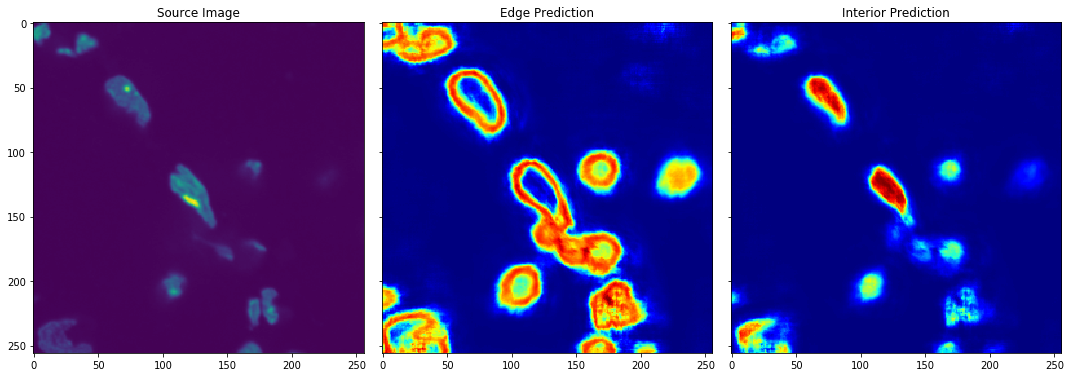

In [8]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 3

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_conv[index, frame, :, :, 0] + test_images_conv[index, frame, :, :, 1], cmap='jet')
ax[1].set_title('Edge Prediction')

ax[2].imshow(test_images_conv[index, frame, :, :, 2], cmap='jet')
ax[2].set_title('Interior Prediction')

fig.tight_layout()
plt.show()

In [9]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

HTML(get_js_video(test_images_conv, batch=0, channel=2))

## Run the Model on an Entire Image

The images we have trained on have been cut into smaller sizes for annotation purposes.  Now that we have a trained model, we can run it on the entire raw image.  Because Z-stacks are quite large, we use a wrapper function `process_whole_image` to slice the raw image into several crops, and stitch the predictions back into place.

In [10]:
from deepcell.utils.data_utils import load_training_images_3d
from deepcell.running import get_cropped_input_shape

whole_images = load_training_images_3d(
    '/data/data/cells/MouseBrain/generic',
    training_direcs=['set0', 'set1'],
    num_frames=30,
    raw_image_direc='raw',
    channel_names=['DAPI'],
    image_size=(1024, 1024))

# get the size of each cropped Z-stack
# it is necessary to re-instatiate the models with this size
cropped_input = get_cropped_input_shape(
    whole_images, num_crops=4, receptive_field=61)

print('Whole Image shape: {}\nCropped Input Shape: {}'.format(
    whole_images.shape[1:], cropped_input))

Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set0/raw, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set1/raw, as num_frames is 30 but there are 41 total frames
Whole Image shape: (30, 1024, 1024, 1)
Cropped Input Shape: (30, 316, 316, 1)


In [11]:
# Re-instantiate the foreground/background model
fgbg_weights_file = '2018-09-15_MouseBrain_3d_nuclear_fgbg.h5'
fgbg_weights_file = os.path.join(MODEL_DIR, fgbg_weights_file)

fgbg_model = bn_feature_net_skip_3D(
    receptive_field=61,
    n_skips=3,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=3,
    input_shape=cropped_input,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False)
fgbg_model.load_weights(fgbg_weights_file)

# Re-instatiate the deepcell model
conv_weights_file = '2018-09-15_MouseBrain_3d_nuclear_conv.h5'
conv_weights_file = os.path.join(MODEL_DIR, PREFIX, conv_weights_file)

run_conv_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_frames=3,
    input_shape=cropped_input,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=True)
run_conv_model.load_weights(conv_weights_file)

In [12]:
from deepcell.running import process_whole_image

output = process_whole_image(
    model=run_conv_model,
    images=whole_images,
    num_crops=4,
    receptive_field=61)
print(output.shape)

(2, 30, 1024, 1024, 4)


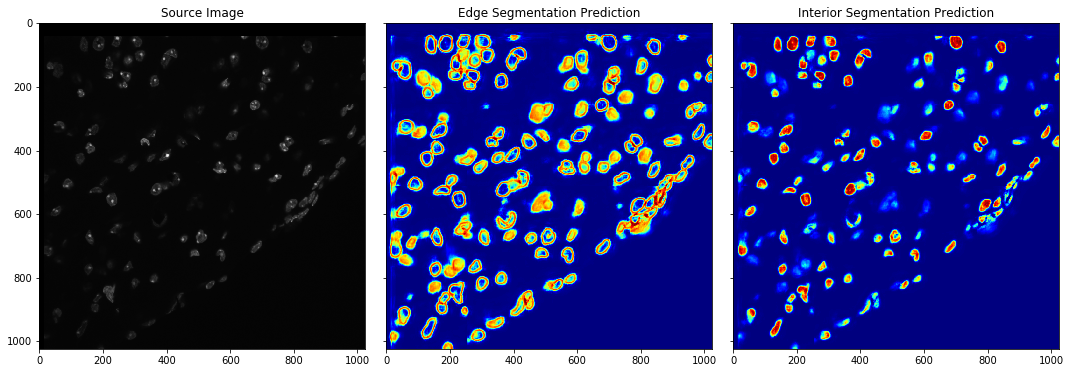

In [15]:
# Plot the results
import matplotlib.pyplot as plt

index = 1
frame = 10

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(whole_images[index, frame, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(output[index, frame, :, :, 0] + output[index, frame, :, :, 1], cmap='jet')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(output[index, frame, :, :, 2], cmap='jet')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()

In [14]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

HTML(get_js_video(output, batch=0, channel=2))